# GCC's ssc-cdi : ptychography pipeline for Cateretê v0.10.0
 
- #### Questions? E-mail gcc@lnls.br

## Imports

In [1]:
import os, json, h5py
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from jupyterlab_h5web import H5Web
import sscCdi
import sscResolution
import sscPimega

print(f'sscCdi version: {sscCdi.__version__}')
print(f'sscPimega version: {sscPimega.__version__}')
print(f'sscResolution version: {sscResolution.__version__}')

sscCdi version: 0.9.6
sscPimega version: 0.8.13
sscResolution version: 0.6


## Inputs

In [21]:
input_dict = {

'beamline': 'CAT',
'detector': '540D',
'debug': False, # use False

"data_folder": "/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/data/ptycho2d/",
"acquisition_folders": ["SSfzp04"],
"projections": [0],

'CPUs': 32,
'GPUs': [0],

# RESTORATION PARAMETERS:
'DP_center': [1134,1126],                   # [center_y, center_x]. if [], will attempt to get the center automatically from direct beam measurement. 
'binning': 1,                               # how many times to bin the data
'using_direct_beam': False,                 # if True, converts DP_center coordinates from raw to restored coordinates
'fill_blanks': False,                       # interpolate blank lines after restoration
'keep_original_negative_values': False,     # if False, all negative values are set to -1
'suspect_border_pixels': 3,                 # pixels. How many pixels in the border to set to null. if 3, means fat border pixels are ignored.
'detector_ROI_radius': 500,                 # pixels. if 0, uses half the detector size. if < 0, will get the the biggest radius possible from the center given in DP_center
'scale': 0.995,                             # scaling factor for pixel projection in restoration. Recommended 0.995
'save_restored_data': False,                # save restored data in the output path
'use_posflat':True,                         # use restored flatfield in images/posflat.hdf5
'use_posmask':False,                        # use restored flatfield in images/posmask.hdf5
    
# PTYCHO PARAMETERS:    
"fresnel_regime": False, # only available for Python engines

'distance_sample_focus': 0, # float. Distance in meters between sample and focus or pinhole. This distance is used to propagated the probe prior to application of the probe support. 

'binning': 1, # how many times to bin data. Must be even number. if 1, no binning occurs.

'position_rotation': 0, # angle in radians. Rotation applied to the positions for correcting angle between detector and probe transverse coordinates

'object_padding': 0, # pixels. Number of pixels to add around the object matrix; required to make sure probe scan does not get out of bounds with object shape. 

'incoherent_modes': 1, # int. Number of incoherent modes to use.

'probe_support': {"type": "circular",  "radius": 1000,  "center_y": 0, "center_x": 0} , # support to be applied to the probe matrix after probe update. Options are:
                                                                                        # - {"type": "circular",  "radius": 300,  "center_y": 0, "center_x": 0} (0,0) is the center of the image
                                                                                        # - {"type": "cross",  "center_width": 300,  "cross_width": 0, "border_padding": 0} 
                                                                                        # - {"type": "array",  "data": myArray}


"initial_obj": {"obj": 'random'},     # 2d array. Initial guess for the object. Options are:
                                      # - {"obj": my2darray}, numpy array 
                                      # - {"obj": 'path/to/numpyFile.npy'}, path to .npy, 
                                      # - {"obj": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                      # - {"obj": 'random'}, random matrix with values between 0 and 1
                                      # - {"obj": 'constant'}, constant matrix of 1s

'initial_probe': { "probe": 'fzp', # creates initial guess based on modelled FZP
                   'beam_type': 'disc',  # 'disc' or 'gaussian'                 
                   'distance_sample_fzpf': 2.9e-3, # distance between sample and fzp focus        
                   'fzp_diameter': 50e-6,               
                   'fzp_outer_zone_width': 50e-9,     
                   'beamstopper_diameter': 20e-6,  # beamstopper placed before fzp. if 0, no beamstopper used      
                   'probe_diameter': 50e-6, # if not included, will use the same diameter s the fzp
                   'probe_normalize':False},  # normalizes fzp probe at end        
                  # - {"probe": my2darray}, numpy array 
                  # - {"probe": 'path/to/numpyFile.npy'}, path to .npy, 
                  # - {"probe": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                  # - {"probe": 'random'}, random matrix with values between 0 and 1
                  # - {"probe": 'constant'}, constant matrix of 1s
                  # - {"probe": 'inverse'}, matrix of the Inverse Fourier Transform of the mean of DPs.
                  # - {"probe": 'circular', "radius": 100, "distance":0},  circular mask with a pixel of "radius". If a distance (in meters) is given, it propagated the round probe using the ASM method 


'algorithms': {

'1': {'name':'PIE',
     'iterations': 30, 
     'step_object': 0.5,
     'step_probe': 1.0,   
     'regularization_object': 0.25,
     'regularization_probe': 0.5,
     'momentum_obj': 0.5,
     'momentum_probe': 0.5, 
     'batch': 64,
     }, 

'2': {'name':'RAAR',
     'iterations': 100, 
     'beta': 1,
     'step_object': 0.9,
     'step_probe': 0.9,   
     'regularization_object': 0.01,
     'regularization_probe': 0.01,
     'momentum_obj': 0.0,
     'momentum_probe': 0.0, 
     'batch': 64 
     },   

# '2': {'name':'AP_PC',
#      'iterations': 100, 
#      'step_object': 0.9,
#      'step_probe': 0.9,      
#      'regularization_object': 0.001,
#      'regularization_probe': 0.001,
#      'momentum_obj': 0.5,
#      'momentum_probe': 0.5, 
#      'batch': 64,
#      },

# '3': {'name':'AP',
#      'iterations': 50, 
#      'step_object': 1.0,
#      'step_probe': 1.0,   
#      'regularization_object': 0.01,
#      'regularization_probe': 0.01,
#      'momentum_obj': 0.5,
#      'momentum_probe': 0.5, 
#      'batch': 64,
#      },   

}
}

input_dict = sscCdi.caterete.cat_ptycho_processing.define_paths(input_dict)
# input_dict

	Proposal path:  /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/data/ptycho2d/
	Acquisition folder:  SSfzp04
	Output path: /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/SSfzp04


### Restoration

In [14]:
restoration_dict_list, restored_data_info_list, filepaths, filenames, folder_names, folder_numbers, input_dict = sscCdi.beamlines.caterete.cat_restoration.restoration_ptycho_CAT(input_dict) # restoration of all frames; restored DPs saved at temporary folder

Using 1 of 2 angle(s)
Restored pixel size: 54.725 um. Pixel size read from metadata: 54.725 um.
{'path': ['/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/data/ptycho2d/SSfzp04/scans/0000_SSfzp04_001.hdf5'], 'outpath': '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/SSfzp04/temp', 'order': 'yx', 'rank': 'ztyx', 'dataset': 'entry/data/data', 'gpus': [0], 'init': 0, 'final': -1, 'saving': 1, 'timing': 0, 'blocksize': 10, 'center': (1126, 1134), 'roi': 500}


### Ptychography


Reading diffraction data for angle #0
	Finished reading diffraction data! DPs shape: (121, 1000, 1000)
Reading probe positions...
	Object pixel size = 28.32 nm
	Limit thickness for resolution of 1 pixel: 25.450 microns
	Finished reading probe positions. Shape: (121, 2)
Data shape: (121, 1000, 1000)
Initial object shape: (1698, 1728)
Initial probe shape: (1000, 1000)
Estimated size for 121 DPs of type float32: 58.56 GBs
Pixel size = 54.73 um
Energy = 6 keV
Wavelength = 0.207 nm


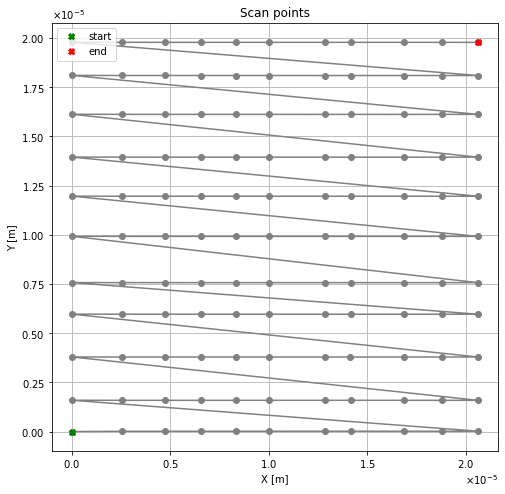

Creating initial probe...
Probe shape (1000,1000) with 1 incoherent mode(s)
probe.shappppppe =  (1, 1000, 1000)
initial_probe.shape =  (1, 1000, 1000)
Creating initial object...
Plotting initial guesses...


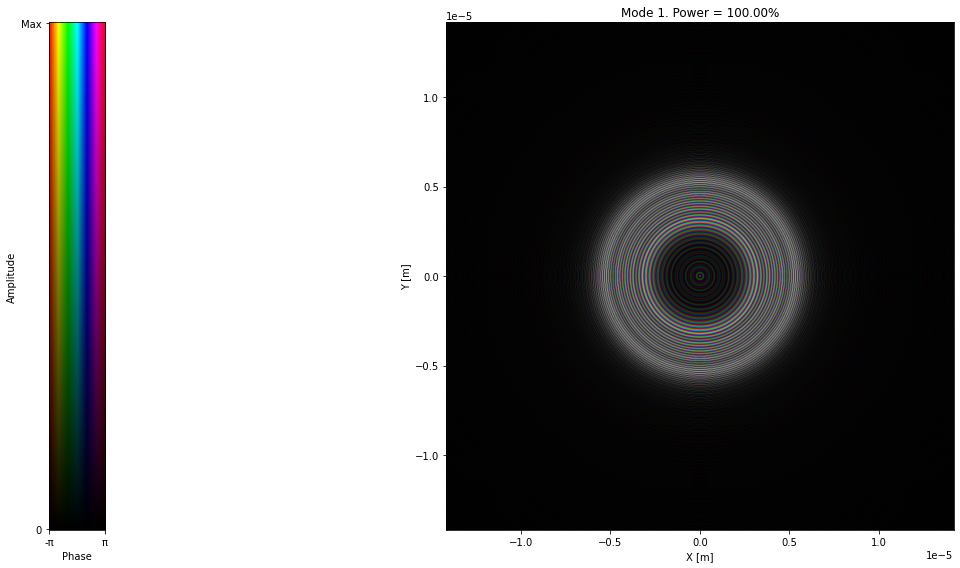

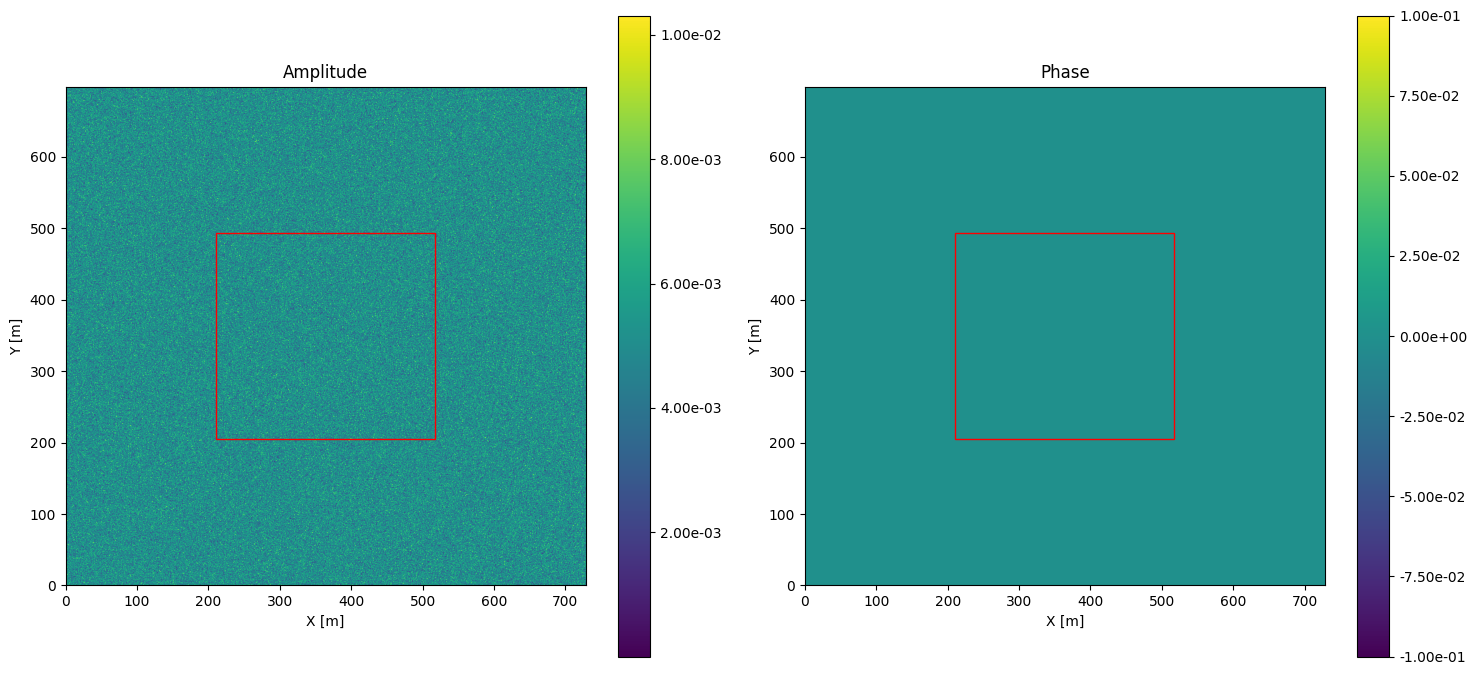

Setting probe support...


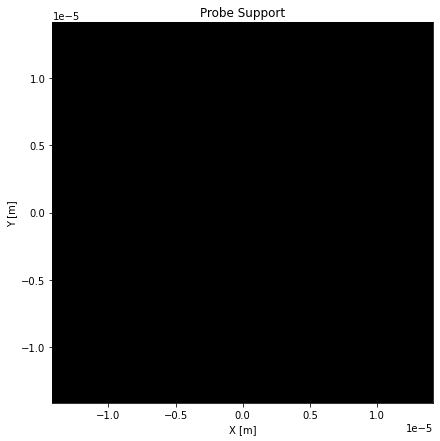

Distance between sample and focus: 0.0mm. Corresponding Fresnel number: 0
Total datapack size: 0.52 GBs
Starting ptychography... using 1 GPUs [0] and 32 CPUs
Calling 30 iterations of ePIE algorithm...
	Done in: 5.37 seconds


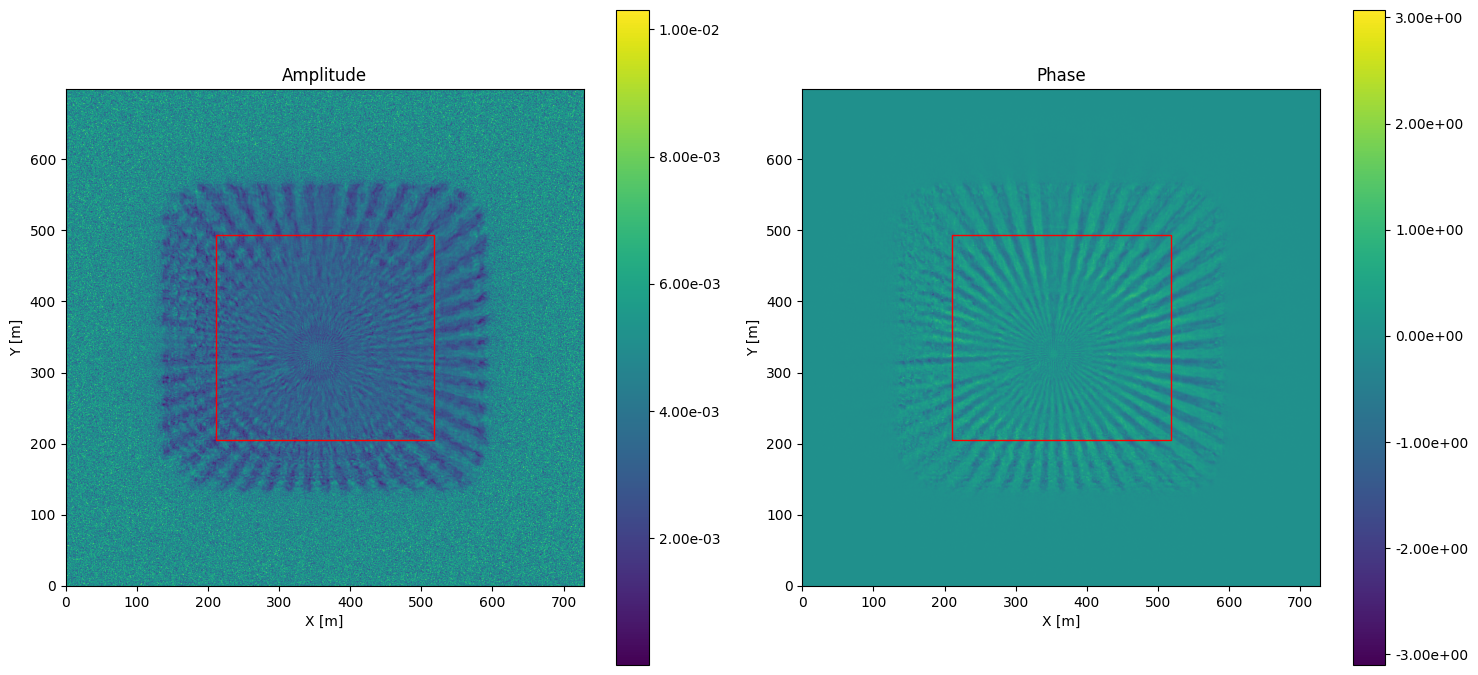

Calling 100 iterations of RAAR algorithm...
Plotting final object and probe...


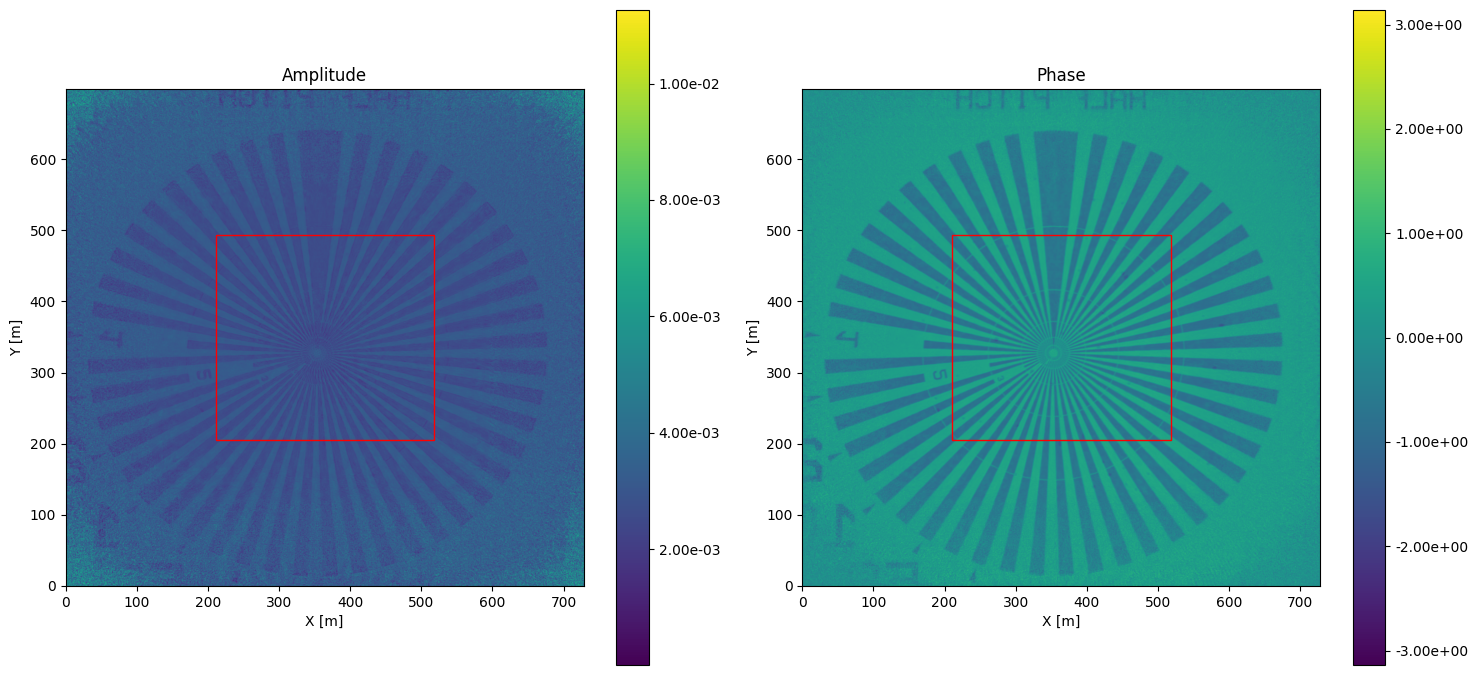

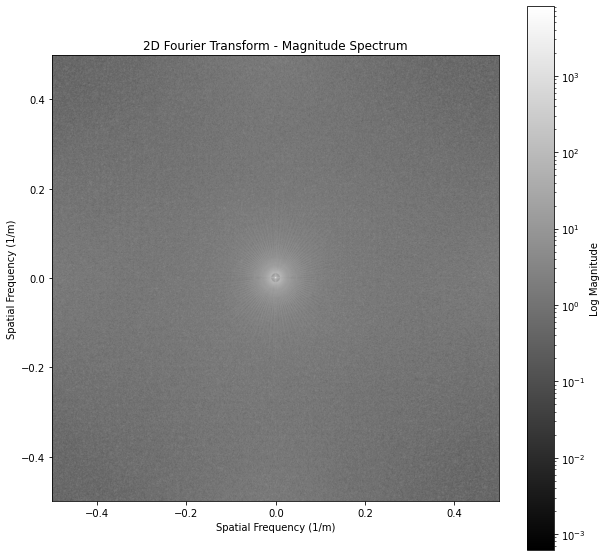

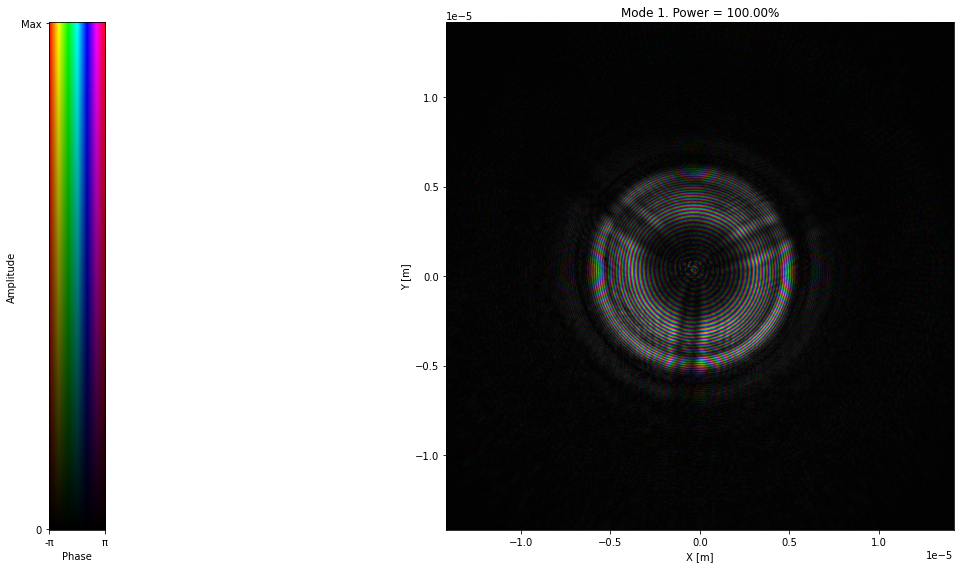

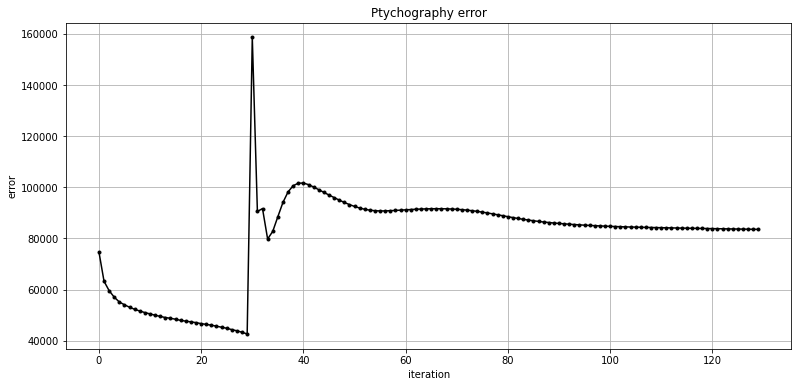

Results saved at:  /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/SSfzp04/000000/2406201351_0000_SSfzp04_001.hdf5
.................................................................................................................


In [15]:
%matplotlib inline
sscCdi.beamlines.caterete.cat_ptycho_processing.cat_ptychography(input_dict,restoration_dict_list,restored_data_info_list,filepaths,filenames,folder_names,folder_numbers) # corrected_positions is an empty list if corrected position algorithm is not used

### Load results

In [16]:
objects, probes, positions, probe_support, error, metadata, angles = sscCdi.read_ptychography_results(input_dict["output_path"], mode='crop', selected_folders=None)

### Plot object (interactive)

In [17]:
sscCdi.ptycho.plots.plot_objects_interactive(objects, positions=positions[0]+probes[0].shape[-1]//2,extent=sscCdi.ptycho.plots.get_plot_extent_from_positions(positions[0]))

interactive(children=(IntSlider(value=0, description='Probe Index', max=1), Output()), _dom_classes=('widget-i…

### Plot probe (interactive)

In [18]:
sscCdi.ptycho.plots.plot_probe_modes_interactive(np.log(probes+1),extent=sscCdi.ptycho.plots.get_extent_from_pixel_size(probes[0,0].shape,input_dict["object_pixel"]))

interactive(children=(IntSlider(value=0, description='Probe Index', max=1), Output()), _dom_classes=('widget-i…

### Plot caustic (interactive)

FloatSlider(value=0.0, continuous_update=False, description='z (mm)', max=15.0, min=-15.0, step=0.5)

FloatRangeSlider(value=(1.0581797435650078e-05, 64553.15372893358), continuous_update=False, description='MinM…

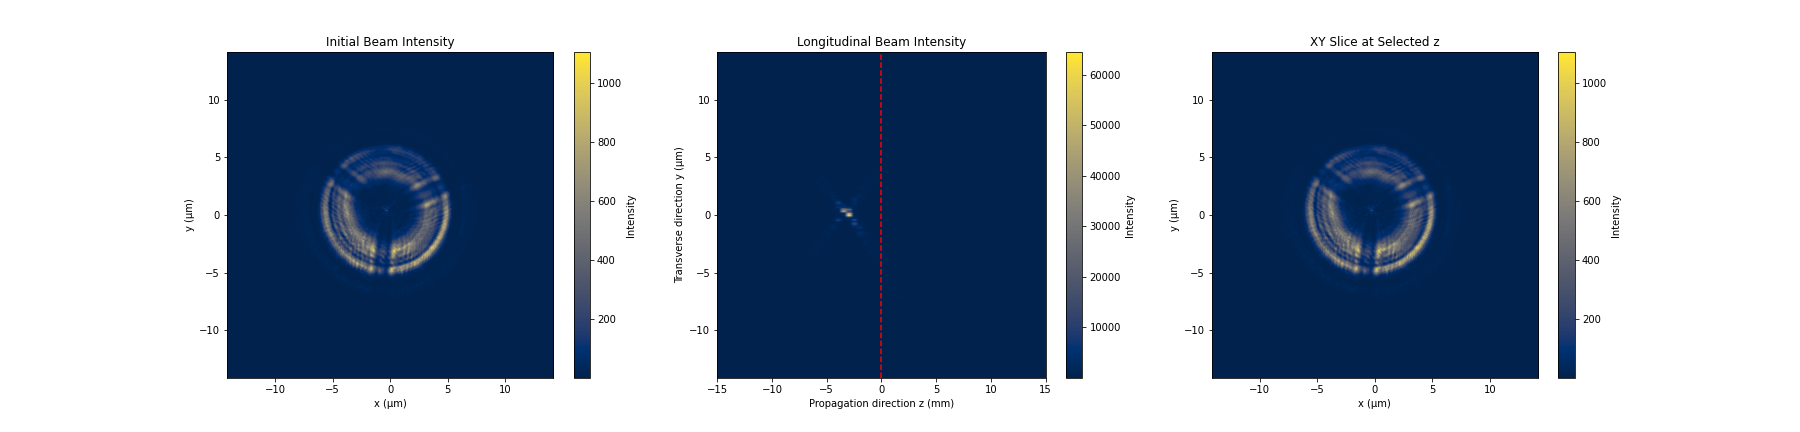

In [19]:
time.sleep(1)
%matplotlib widget
dz = 5e-4  # Step size in propagation direction in meters
z_range = 15e-3  # Range of propagation in meters
sscCdi.ptycho.plots.plot_caustic(probes[0,0],input_dict['wavelength'], dz, z_range, input_dict['object_pixel'],direction='vertical')